In [100]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory
import seaborn as sns
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(1991)
torch.manual_seed(1991)
torch.cuda.manual_seed(1991)

import random
random.seed(1991)

import numpy as np
np.random.seed(1991)

Running on device: CUDA


In [101]:
# CIFAR 10 dataset
torch.manual_seed(1991)
# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [102]:
# Unlearning algorithm
def unlearning(net, retain, forget, validation, epochs):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [127]:
from sklearn.linear_model import LogisticRegression

def train_mia_on_class(model, class_index, train_set, test_set, no_class=True, splits_num=5):
  model = model.to("cpu")

  if not no_class:
    # Select indencies where class is class_index
    train_class_set = np.where(np.array(train_set.targets) == class_index)[0]
    test_class_set = np.where(np.array(test_set.targets) == class_index)[0]
  else:
    train_class_set = np.arange(len(train_set))
    test_class_set = np.arange(len(test_set))

  max_len = min([len(train_class_set), len(test_class_set)])
  # Make equal sizes
  train_class_set = train_class_set[:max_len]
  test_class_set = test_class_set[:max_len]

  # Obtain subsets
  train_class_set = torch.utils.data.Subset(train_set, train_class_set)
  test_class_set = torch.utils.data.Subset(test_set, test_class_set)


  # Make them
  class_test_loader = torch.utils.data.DataLoader(
    test_class_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )

  class_train_loader = torch.utils.data.DataLoader(
    train_class_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )

  criterion = nn.CrossEntropyLoss(reduction="none")
  # Obtain train and test logits
  logits_train = []
  for i, (images, labels) in enumerate(class_train_loader, 0):
    for img, label in zip(images, labels):
      logits = model(img.unsqueeze(0))
      losses = criterion(logits, label.unsqueeze(0)).numpy(force=True)

      logits_train.append(np.concatenate((logits.detach().numpy()[0], losses)))

  logits_test = []
  for i, (images, labels) in enumerate(class_test_loader, 0):
    for img, label in zip(images, labels):
      logits = model(img.unsqueeze(0))
      losses = criterion(logits, label.unsqueeze(0)).numpy(force=True)

      logits_test.append((np.concatenate((logits.detach().numpy()[0], losses))))

  logits_train, logits_test = np.array(logits_train), np.array(logits_test)
  # Create dataset
  ys = [1] * max_len + [0] * max_len
  ys = np.array(ys)
  p = np.random.permutation(len(ys))
  logits = np.concatenate((logits_train, logits_test))

  logits = logits[p]
  ys = ys[p]

  # Fit logitstic regression
  clf = LogisticRegression(random_state=0, max_iter=1000)
  cv = model_selection.StratifiedShuffleSplit(
        n_splits=splits_num, random_state=0
    )

  clf = model_selection.cross_val_score(
        clf, logits, ys, cv=cv, scoring="accuracy"
    )

  # Output score
  # print(f"Mean MIA attack score for class {class_index} is: " + str(clf.mean()))
  return clf.mean()

In [121]:

# Check accuracy

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader, 0):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [122]:

def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


## Перевірка взаємозалежності між кількістю даних для Forget set і результатом алгоритму

In [154]:
print("----- 1 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.01

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader, 5)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)

----- 1 PERCENT -------
Model name: Resnet18 Baseline
Amount: 1.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 96.0
MIA score before on forget set: 0.95


Retain set accuracy FORGET model: 99.3%
Test set accuracy FORGET model: 76.6%
Forget set accuracy FORGET model: 80.0%

The MIA has an accuracy of 0.840 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 100.0
MIA score before on forget set: 0.9


Retain set accuracy FORGET model: 98.3%
Test set accuracy FORGET model: 76.2%
Forget set accuracy FORGET model: 88.0%

The MIA has an accuracy of 0.920 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 94.0
MIA score before on forget set: 0.8


Retain set accuracy FORGET model: 98.6%
Test set accuracy FORGET model: 76.6%
Forget set accuracy FORGET model: 70.0%

The MIA has an accuracy of 0.840 on forgotten vs 

In [155]:
mean_mia_score_before_1p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_1p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_1p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_1p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_1p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_1p = np.mean(np.array(Accuracy_test))

In [156]:
mean_mia_score_before_1p

0.8800000000000001

In [157]:
print("----- 1 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.02

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader, 5)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)

----- 1 PERCENT -------
Model name: Resnet18 Baseline
Amount: 2.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 96.0
MIA score before on forget set: 0.925


Retain set accuracy FORGET model: 94.2%
Test set accuracy FORGET model: 75.5%
Forget set accuracy FORGET model: 86.0%

The MIA has an accuracy of 0.950 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 95.0
MIA score before on forget set: 0.925


Retain set accuracy FORGET model: 85.7%
Test set accuracy FORGET model: 73.7%
Forget set accuracy FORGET model: 77.0%

The MIA has an accuracy of 0.850 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 91.0
MIA score before on forget set: 0.875


Retain set accuracy FORGET model: 93.9%
Test set accuracy FORGET model: 74.5%
Forget set accuracy FORGET model: 87.0%

The MIA has an accuracy of 0.870 on forgotten

In [158]:
mean_mia_score_before_2p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_2p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_2p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_2p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_2p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_2p = np.mean(np.array(Accuracy_test))

In [159]:
print("----- 5 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.05

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader, 5)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)

----- 5 PERCENT -------
Model name: Resnet18 Baseline
Amount: 5.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 96.8
MIA score before on forget set: 0.88


Retain set accuracy FORGET model: 98.7%
Test set accuracy FORGET model: 76.4%
Forget set accuracy FORGET model: 87.2%

The MIA has an accuracy of 0.900 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 97.6
MIA score before on forget set: 0.94


Retain set accuracy FORGET model: 99.2%
Test set accuracy FORGET model: 76.7%
Forget set accuracy FORGET model: 88.8%

The MIA has an accuracy of 0.916 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 88.8
MIA score before on forget set: 0.9


Retain set accuracy FORGET model: 94.2%
Test set accuracy FORGET model: 74.8%
Forget set accuracy FORGET model: 64.8%

The MIA has an accuracy of 0.928 on forgotten vs 

In [160]:
mean_mia_score_before_5p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_5p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_5p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_5p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_5p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_5p = np.mean(np.array(Accuracy_test))

In [161]:
print("----- 10 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.1

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader, 5)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)

----- 10 PERCENT -------
Model name: Resnet18 Baseline
Amount: 10.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 95.8
MIA score before on forget set: 0.95


Retain set accuracy FORGET model: 96.0%
Test set accuracy FORGET model: 75.5%
Forget set accuracy FORGET model: 83.8%

The MIA has an accuracy of 0.866 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 96.8
MIA score before on forget set: 0.945


Retain set accuracy FORGET model: 95.6%
Test set accuracy FORGET model: 74.3%
Forget set accuracy FORGET model: 87.8%

The MIA has an accuracy of 0.914 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 94.0
MIA score before on forget set: 0.9


Retain set accuracy FORGET model: 99.7%
Test set accuracy FORGET model: 76.5%
Forget set accuracy FORGET model: 79.2%

The MIA has an accuracy of 0.894 on forgotten 

In [162]:
mean_mia_score_before_10p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_10p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_10p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_10p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_10p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_10p = np.mean(np.array(Accuracy_test))

In [163]:
mean_mia_before = [mean_mia_score_before_1p, mean_mia_score_before_2p, mean_mia_score_before_5p, mean_mia_score_before_10p]
mean_mia_after = [mean_mia_score_after_1p, mean_mia_score_after_2p, mean_mia_score_after_5p, mean_mia_score_after_10p]

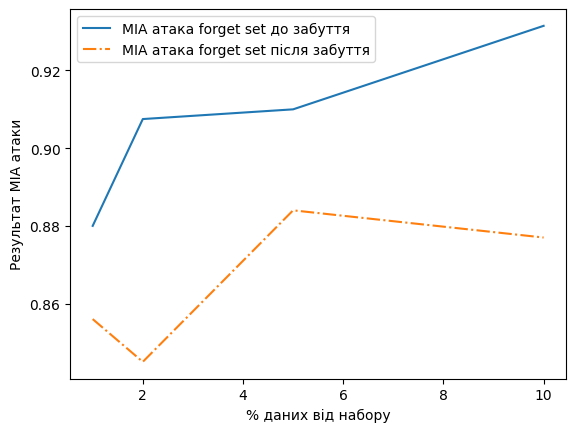

In [164]:
import matplotlib.pyplot as plt

x = [1, 2, 5, 10]

plt.plot(x, mean_mia_before, label ='MIA атака forget set до забуття')
plt.plot(x, mean_mia_after, '-.', label ='MIA атака forget set після забуття')

plt.xlabel("% даних від набору")
plt.ylabel("Результат MIA атаки")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [165]:
mean_accuracy_before = [mean_accuracy_forget_before_1p, mean_accuracy_forget_before_2p, mean_accuracy_forget_before_5p, mean_accuracy_forget_before_10p]
mean_accuracy_after = [mean_accuracy_forget_after_1p, mean_accuracy_forget_after_2p, mean_accuracy_forget_after_5p, mean_accuracy_forget_after_10p]

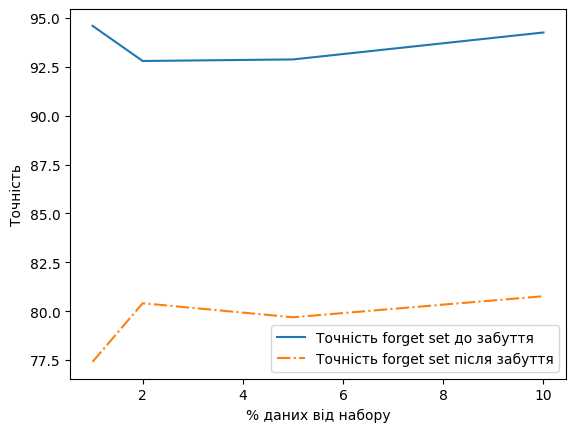

In [166]:
import matplotlib.pyplot as plt

x = [1, 2, 5, 10]

plt.plot(x, mean_accuracy_before, label ='Точність forget set до забуття')
plt.plot(x, mean_accuracy_after, '-.', label ='Точність forget set після забуття')

plt.xlabel("% даних від набору")
plt.ylabel("Точність")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [167]:
mean_accuracy_retain = [mean_accuracy_retain_1p, mean_accuracy_retain_2p, mean_accuracy_retain_5p, mean_accuracy_retain_10p]
mean_accuracy_test = [mean_accuracy_test_1p, mean_accuracy_test_2p, mean_accuracy_test_5p, mean_accuracy_test_10p]

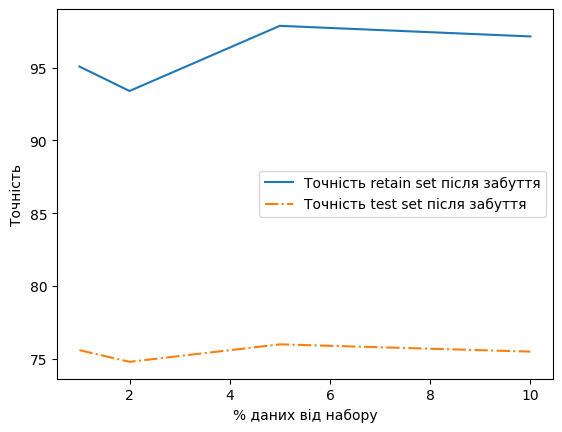

In [168]:
import matplotlib.pyplot as plt

x = [1, 2, 5, 10]

plt.plot(x, mean_accuracy_retain, label ='Точність retain set після забуття')
plt.plot(x, mean_accuracy_test, '-.', label ='Точність test set після забуття')

plt.xlabel("% даних від набору")
plt.ylabel("Точність")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [150]:
print("----- Unlearning check by epochs -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.05
epoch_num = 5
# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader, epoch_num)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)

----- Unlearning check by epochs -------
Model name: Resnet18 Baseline
Amount: 5.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 95.19999999999999
MIA score before on forget set: 0.91




KeyboardInterrupt: 